# Simple Boosting Experiment

(569, 30)
(569,)
Class 0:  0.373
Class 1:  0.627


<IPython.core.display.Javascript object>


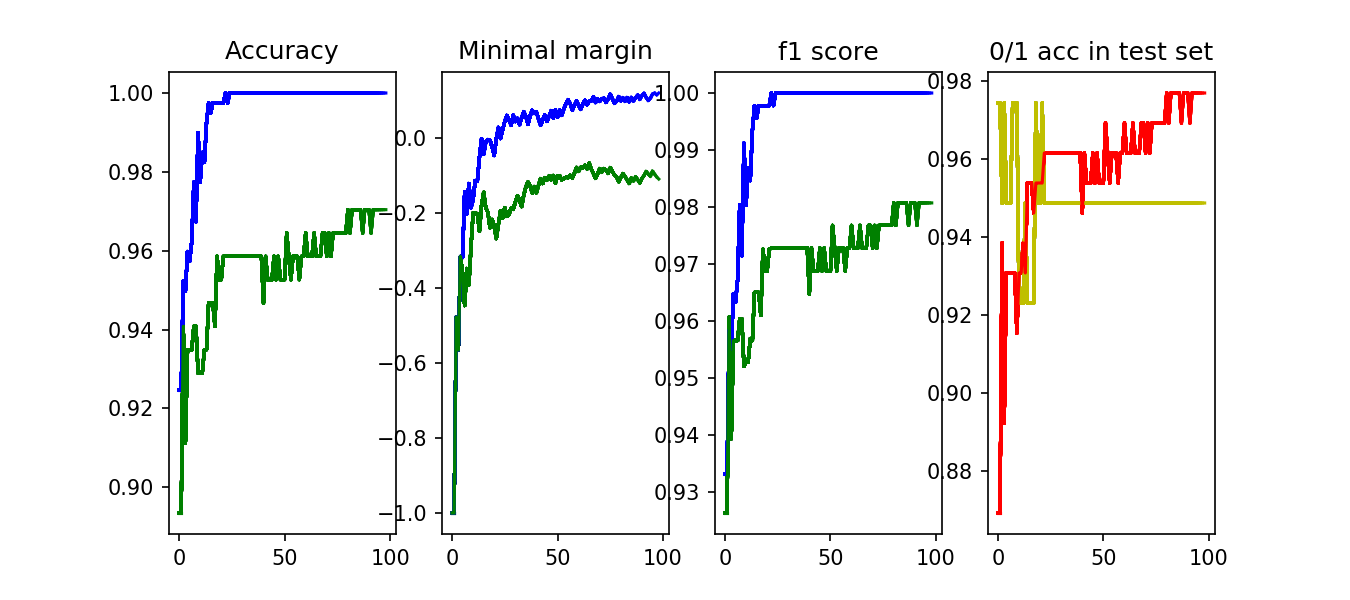

Iter.	acc_train  acc_test   mm_in      mm_test    f1_train   f1_test    acc0_test  acc1_test 
1 	0.924623   0.893491   -1.000000  -1.000000  0.933036   0.926230   0.974359   0.869231   
2 	0.924623   0.893491   -1.000000  -1.000000  0.933036   0.926230   0.974359   0.869231   
3 	0.952261   0.940828   -0.477646  -0.477646  0.958425   0.960630   0.948718   0.938462   
4 	0.949749   0.911243   -0.564634  -0.564634  0.954955   0.939271   0.974359   0.892308   
5 	0.959799   0.934911   -0.315314  -0.315314  0.964758   0.956522   0.948718   0.930769   
6 	0.957286   0.934911   -0.318179  -0.361199  0.963283   0.956522   0.948718   0.930769   
7 	0.962312   0.934911   -0.142483  -0.446343  0.967177   0.956522   0.948718   0.930769   
8 	0.977387   0.940828   -0.201091  -0.347490  0.980392   0.960317   0.974359   0.930769   
9 	0.967337   0.940828   -0.120678  -0.391176  0.971429   0.960317   0.974359   0.930769   
10 	0.989950   0.928994   -0.185169  -0.289145  0.991189   0.952000   0.974359

89 	1.000000   0.970414   0.115444   -0.110296  1.000000   0.980695   0.948718   0.976923   
90 	1.000000   0.970414   0.103999   -0.119425  1.000000   0.980695   0.948718   0.976923   
91 	1.000000   0.970414   0.113802   -0.107176  1.000000   0.980695   0.948718   0.976923   
92 	1.000000   0.964497   0.120085   -0.099328  1.000000   0.976744   0.948718   0.969231   
93 	1.000000   0.970414   0.109076   -0.088524  1.000000   0.980695   0.948718   0.976923   
94 	1.000000   0.970414   0.101045   -0.095124  1.000000   0.980695   0.948718   0.976923   
95 	1.000000   0.970414   0.106932   -0.101051  1.000000   0.980695   0.948718   0.976923   
96 	1.000000   0.970414   0.117693   -0.087783  1.000000   0.980695   0.948718   0.976923   
97 	1.000000   0.970414   0.120758   -0.095578  1.000000   0.980695   0.948718   0.976923   
98 	1.000000   0.970414   0.115878   -0.103063  1.000000   0.980695   0.948718   0.976923   
99 	1.000000   0.970414   0.120936   -0.108706  1.000000   0.980695   

In [86]:
%matplotlib notebook

from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_digits

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

def p(lst):
    s = ""
    for l in lst: s += str(round(l, 4)) + "\t"
    return s

def ada_boost(X, y, depth, estimators):
    n, d = X.shape
    
    split = int(n*0.7)
    
    X_train = X[:split]
    y_train = y[:split]
    X_test  = X[split+1: -1]
    y_test  = y[split+1: -1]

    ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=depth),  algorithm="SAMME", n_estimators=estimators)
    ada.fit(X_train, y_train)

    # compute in+out of sample error
    acc_train = ada.score(X_train, y_train)
    acc_test  = ada.score(X_test, y_test)

    # compute in+out margin
    H_train = ada.decision_function(X_train)
    H_test  = ada.decision_function(X_test)
    mm_train = np.min(H_train * (y_train*2-1))
    mm_test  = np.min(H_test  * (y_test *2-1))

    # compute in+out precision recall. ?? F1?
    f1_train = f1_score(y_train, ada.predict(X_train))
    f1_test  = f1_score(y_test, ada.predict(X_test))
    
    # accuracy on each class in test set
    acc0_test = ada.score(X_test[y_test == 0], np.zeros(sum(y_test==0)))
    acc1_test = ada.score(X_test[y_test == 1], np.ones(sum(y_test==1)))
    
    return acc_train, acc_test, mm_train, mm_test, f1_train, f1_test, acc0_test, acc1_test

def experiment(X, y, depth, interval): 
    # visualization stuff
    plot_acc_train  = []
    plot_acc_test   = []
    plot_mm_train = []
    plot_mm_test  = []
    plot_f1_train = []
    plot_f1_test  = []
    plot_acc0_test = []
    plot_acc1_test = []

    fig, (ax_acc, ax_margin, ax_f1, ax_acc01) = plt.subplots(1, 4, figsize=(9,4)) 
    # end visualization stuff. 

    print("Iter.\t%-10s %-10s %-10s %-10s %-10s %-10s %-10s %-10s"%
          ("acc_train", "acc_test", "mm_in", "mm_test", "f1_train", "f1_test", "acc0_test", "acc1_test"))
    for i in interval:
        vals = ada_boost(X, y, depth, i)
        plot_acc_train.append(vals[0])
        plot_acc_test.append(vals[1])
        plot_mm_train.append(vals[2])
        plot_mm_test.append(vals[3])
        plot_f1_train.append(vals[4])
        plot_f1_test.append(vals[5])
        plot_acc0_test.append(vals[6])
        plot_acc1_test.append(vals[7])

        ax_acc.plot(plot_acc_train, color='b')
        ax_acc.plot(plot_acc_test, color='g')
        ax_acc.set_title("Accuracy")

        ax_margin.plot(plot_mm_train, color='b')
        ax_margin.plot(plot_mm_test, color='g')
        ax_margin.set_title("Minimal margin")

        ax_f1.plot(plot_f1_train, color='b')
        ax_f1.plot(plot_f1_test, color='g')
        ax_f1.set_title("f1 score")

        ax_acc01.plot(plot_acc0_test, color='y')
        ax_acc01.plot(plot_acc1_test, color='r')
        ax_acc01.set_title("0/1 acc in test set")

        fig.canvas.draw()

        print(i, "\t%-10f %-10f %-10f %-10f %-10f %-10f %-10f %-10f "%(vals))
        
        
X, y = load_breast_cancer(True)
#X, y = load_digits(2, True) # similar to mnist but 8x8 (doesn't work?)
print(X.shape)
print(y.shape)
print("Class 0: ", round(sum(y==0)/y.size, 3))
print("Class 1: ", round(sum(y==1)/y.size, 3))
# TODO: consider shuffling data initially. 

depth = 1
interval = range(1, 100)
experiment(X, y, depth, interval)